In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import os

In [2]:
country_mapping = {
    'AUT': 1.0,
    'BEL': 4.0,
    'CHE': 6.0,
    'CZE': 8.0,
    'DEU': 9.0,
    'DNK': 10.0,
    'ESP': 13.0,
    'EST': 11.0,
    'FIN': 14.0,
    'FRA': 15.0,
    'GBR': 39.0,
    'HRV': 16.0,
    'HUN': 17.0,
    'IRL': 18.0,
    'ITA': 20.0,
    'LTU': 22.0,
    'LVA': 24.0,
    'NLD': 29.0,
    'NOR': 30.0,
    'POL': 31.0,
    'PRT': 32.0,
    'SVK': 37.0,
    'SVN': 36.0,
    'SWE': 35.0,
}

countries = list(country_mapping.keys())

In [3]:
ENERGY_FOLDER_LENTIS = "/net/pc200256//nobackup/users/most/output/LENTIS_2023_PD/agg_production/per_country/"
RUNNAME_LENTIS = "LENTIS_2023_PD"
ENERGY_FOLDER_ERA = "/net/pc200256/nobackup/users/most/output/ERA5_2023_PD/agg_production/per_country/"
RUNNAME_ERA = "ERA5_2023_PD_noHydro"
SEASON_MONTHS = [11, 12, 1, 2, 3]

ED_FILENAME_LENTIS = "netto_demand_el7_winter_LENTIS_2023_PD_1600_events.csv"
ED_FILENAME_ERA = "demand_net_renewables_netto_demand_el7_winter_ERA5_2023_PD_noHydro_73_events_v2.csv"
PATH_ED = "/usr/people/duinen/MSc-thesis/src/find_energydroughts/data/"

ed_lentis = pd.read_csv(
    os.path.join(PATH_ED, ED_FILENAME_LENTIS),
).reset_index(drop=True)
#ed_lentis["run"] = ed_lentis["runs"].str.extract(r"(\d+)").astype(int)
df_events_lentis = ed_lentis.drop(["Unnamed: 0"], axis=1)

ed_era = pd.read_csv(
    os.path.join(
        PATH_ED,
        ED_FILENAME_ERA,
    ),
).reset_index(drop=True)
df_events_era = ed_era.drop(["Unnamed: 0"], axis=1)

In [4]:
def get_energy_data(country, type):
    if type == 'lentis':
        return xr.open_dataset(ENERGY_FOLDER_LENTIS + f"{country}_{RUNNAME_LENTIS}.nc")
    elif type == 'era':
        return xr.open_dataset(ENERGY_FOLDER_ERA + f"{country}_{RUNNAME_ERA}.nc")
    
def production_ratio(country, energytype, times):
    data_lentis = get_energy_data(country, 'lentis')
    data_era = get_energy_data(country, 'era')
    if energytype == 'wind':
        data_lentis = data_lentis.wind_onshore + data_lentis.wind_offshore
        data_era = data_era.wind_onshore + data_era.wind_offshore
    else:
        data_lentis = data_lentis[energytype]
        data_era = data_era[energytype]

    if times == 'all':
        production_lentis = data_lentis.sel(time=data_lentis.time.dt.month.isin(SEASON_MONTHS)).mean(dim = ['time', 'runs']).to_numpy()[0]
        production_era = data_era.sel(time=data_era.time.dt.month.isin(SEASON_MONTHS)).mean(dim = ['time', 'runs']).to_numpy()[0]
    elif times == 'events':
        date_range_country_era = []
        df_events_era_country = df_events_era.query("country == @country")
        for i, row in df_events_era_country.iterrows():
            date_range_country_era.extend(
                pd.date_range(
                    start=row["start_time"], end=row["end_time"], freq="D"
                )
            )

        date_range_country_lentis = []
        runs_country_lentis = []
        df_events_lentis_country = df_events_lentis.query('country == @country')
        for i, row in df_events_lentis_country.iterrows():
            date_range_country_lentis.extend(
                pd.date_range(
                    start=row["start_time"], end=row["end_time"], freq="D"
                )
            )
            runs_country_lentis.extend([row["runs"]] * 7)
        data_lentis_stack = data_lentis.stack(event = ['time', 'runs'])
        event_tuples = list(zip(date_range_country_lentis, runs_country_lentis))
        full_lentis = data_lentis_stack.sel(event = event_tuples)
        production_lentis = full_lentis.mean(dim = ['event']).to_numpy()[0]
        production_era = data_era.sel(time = date_range_country_era).mean(dim = ['time', 'runs']).to_numpy()[0]
    data_lentis.close()
    data_era.close()
    return production_lentis / production_era


In [5]:
demand_ratios = []
for country in tqdm(country_mapping):
    demand_ratios.append(production_ratio(country, 'demand', 'all'))

  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
solar_ratios = []
for country in tqdm(country_mapping):
    solar_ratios.append(production_ratio(country, 'pv_util', 'all'))

  0%|          | 0/24 [00:00<?, ?it/s]

In [7]:
wind_ratios = []
for country in tqdm(country_mapping):
    wind_ratios.append(production_ratio(country, 'wind', 'all'))

  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era


In [8]:
ror_ratios = []
for country in tqdm(country_mapping):
    ror_ratios.append(production_ratio(country, 'ror', 'all'))

  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era


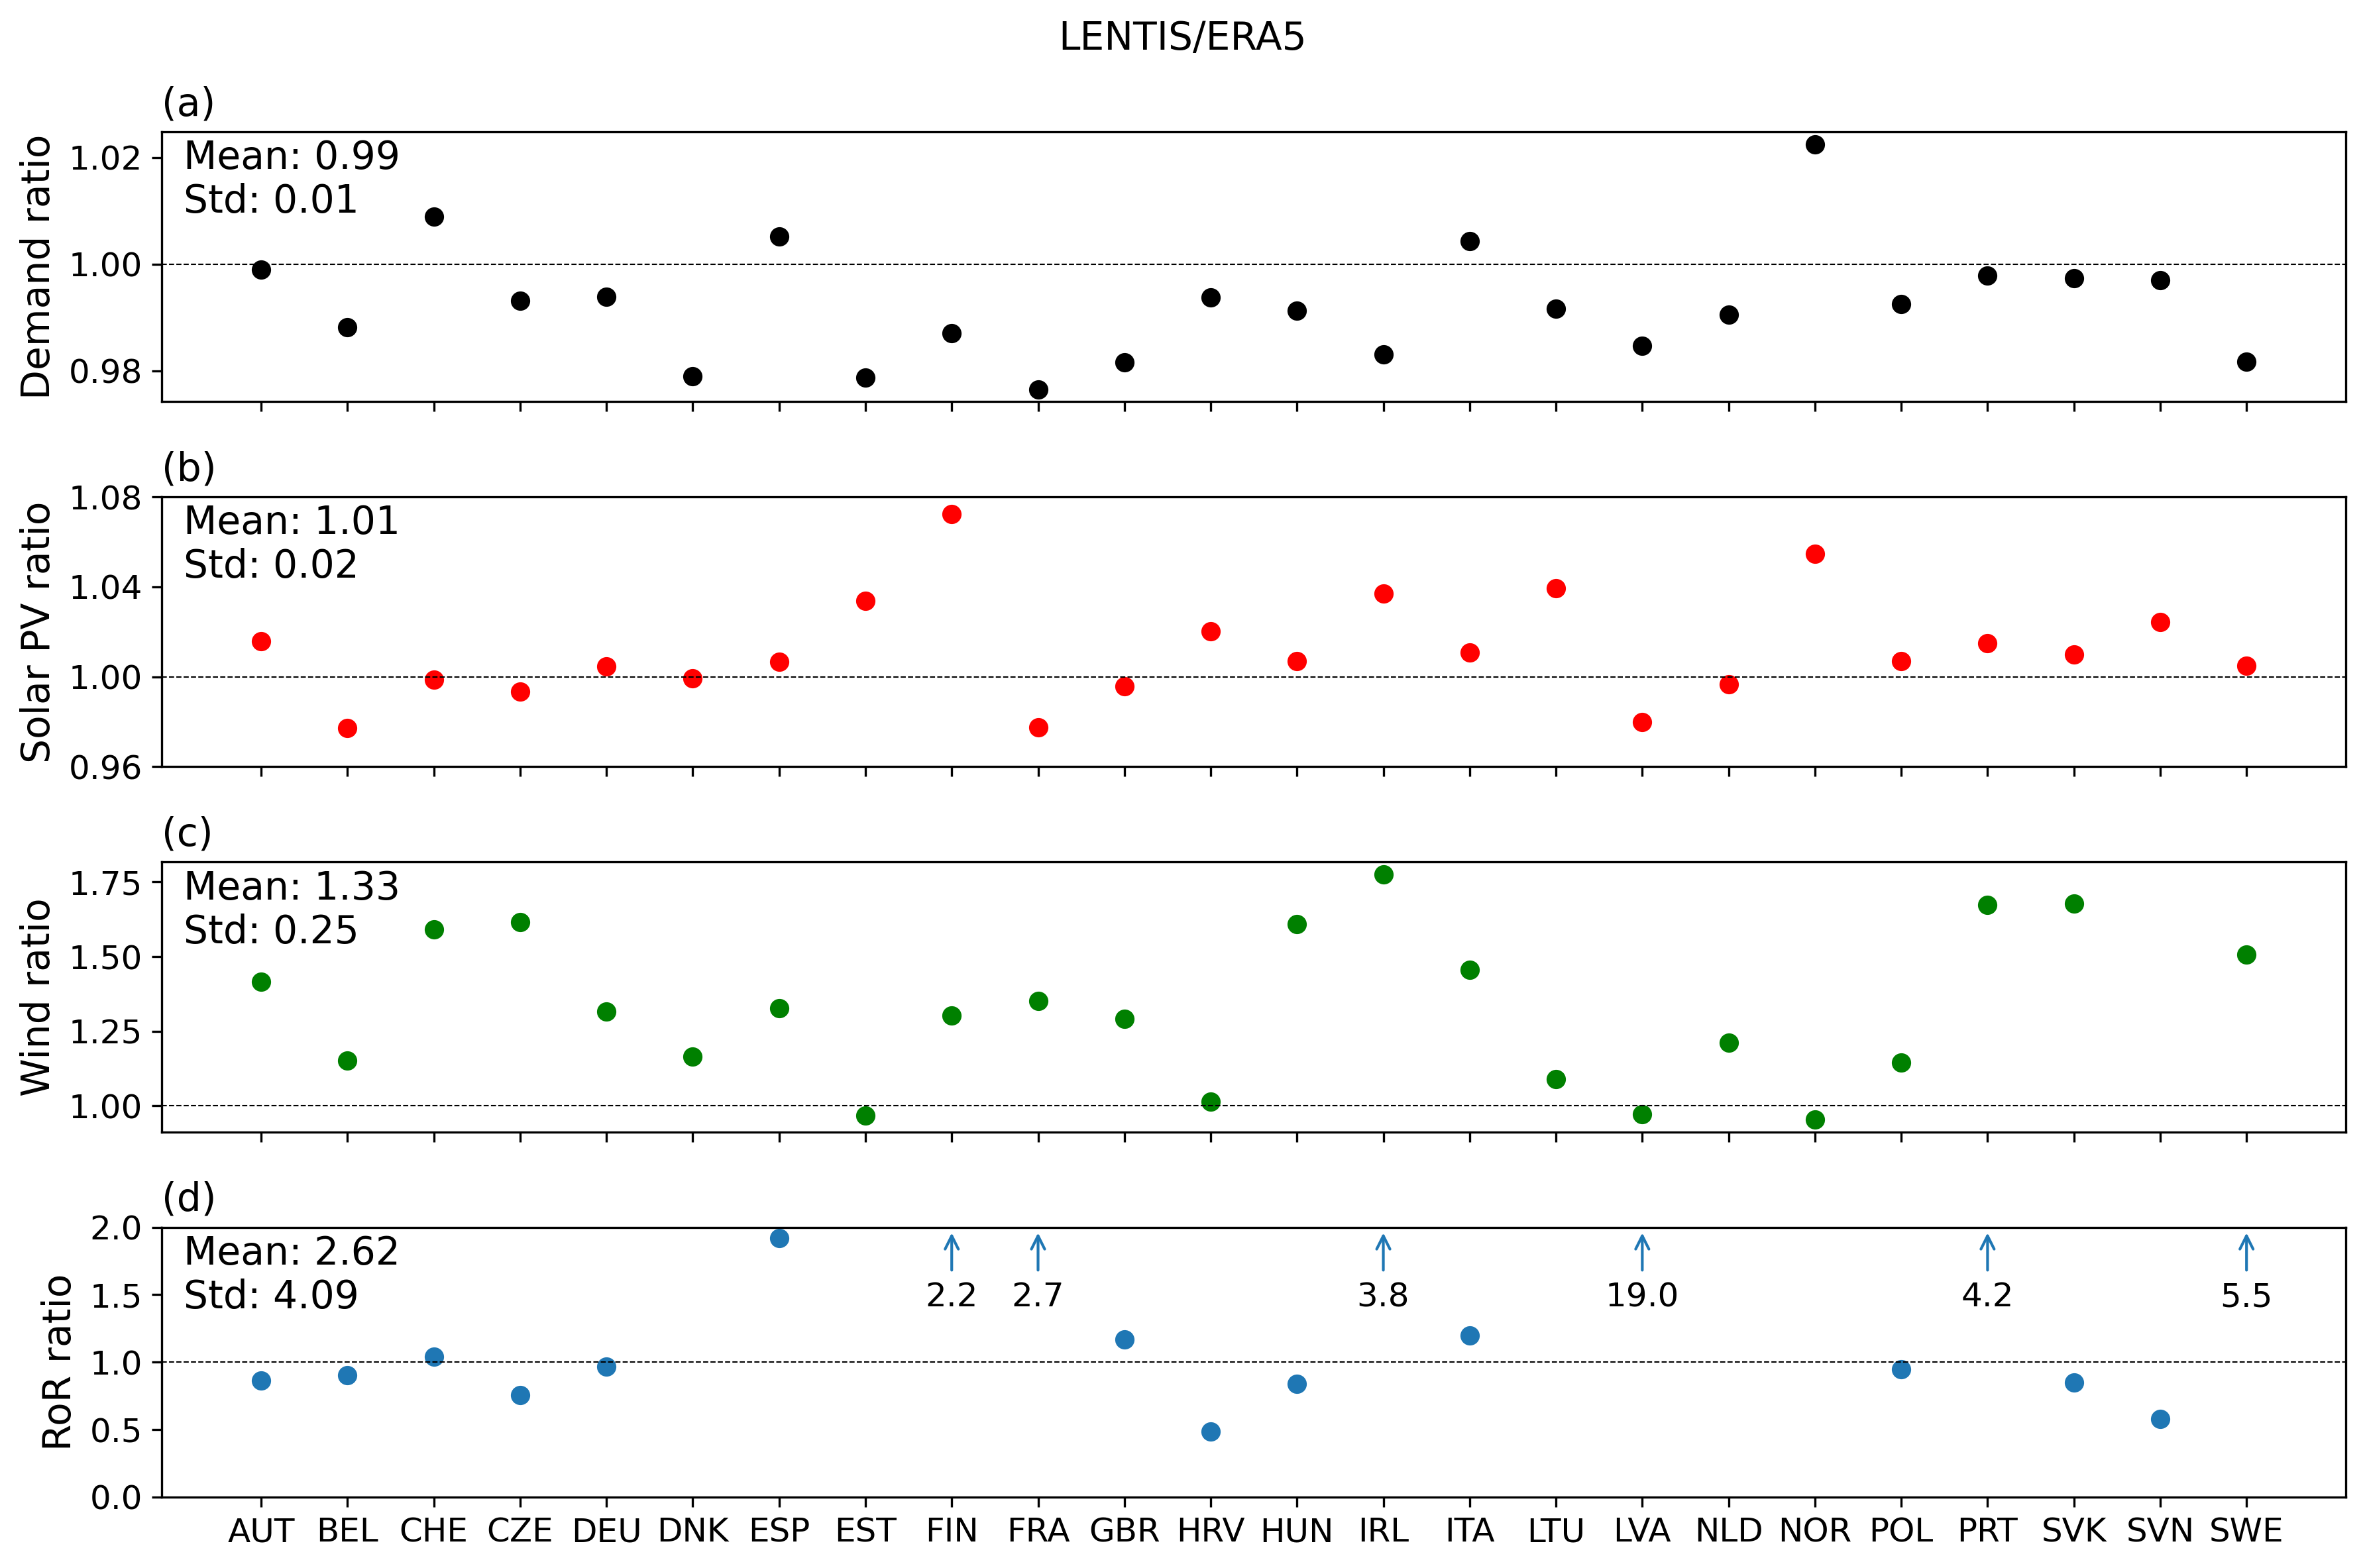

In [14]:
fontsize_l = 14
fontsize_s = 12

fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True, dpi = 300)

axs[0].scatter(countries, demand_ratios, color = 'k')
axs[0].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[0].set_ylabel('Demand ratio', fontsize=fontsize_l)
axs[0].text(0.01, 0.7, f"Mean: {np.mean(demand_ratios):.2f}\nStd: {np.std(demand_ratios):.2f}", transform=axs[0].transAxes, fontsize=fontsize_l)
axs[0].set_title('(a)', loc = "left", fontsize=fontsize_l)
axs[0].tick_params(axis='both', labelsize=fontsize_s)

axs[1].scatter(countries, solar_ratios, color = 'r')
axs[1].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[1].set_ylabel('Solar PV ratio', fontsize=fontsize_l)
axs[1].text(0.01, 0.7, f"Mean: {np.mean(solar_ratios):.2f}\nStd: {np.std(solar_ratios):.2f}", transform=axs[1].transAxes, fontsize=fontsize_l)
axs[1].set_ylim(0.97, 1.08)
axs[1].set_yticks(np.arange(0.96, 1.08, 0.04))
axs[1].set_title('(b)', loc = "left", fontsize=fontsize_l)
axs[1].tick_params(axis='both', labelsize=fontsize_s)

axs[2].scatter(countries, wind_ratios, color = 'g')
axs[2].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[2].set_ylabel('Wind ratio', fontsize=fontsize_l)
axs[2].text(0.01, 0.7, f"Mean: {np.nanmean(wind_ratios):.2f}\nStd: {np.nanstd(wind_ratios):.2f}", transform=axs[2].transAxes, fontsize=fontsize_l)
axs[2].set_title('(c)', loc = "left", fontsize=fontsize_l)
axs[2].tick_params(axis='both', labelsize=fontsize_s)

axs[3].scatter(countries, ror_ratios, color = 'C0')
axs[3].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
plt.ylim(0, 2)
axs[3].set_ylabel('RoR ratio', fontsize=fontsize_l)
axs[3].text(0.01, 0.7, f"Mean: {np.nanmean(ror_ratios):.2f}\nStd: {np.nanstd(ror_ratios):.2f}", transform=axs[3].transAxes, fontsize=fontsize_l)
indices = np.where(np.array(ror_ratios) >= 2)[0]
for i in indices:
    axs[3].annotate(round(ror_ratios[i], 1), xy=(countries[i], 2), xytext=(countries[i], 1.6),
                    textcoords='data', ha='center', va='top',
                    arrowprops=dict(color='C0', arrowstyle='->', connectionstyle='arc3,rad=0'), fontsize=fontsize_s)
axs[3].set_title('(d)', loc = "left", fontsize=fontsize_l)
axs[3].tick_params(axis='both', labelsize=fontsize_s)


fig.suptitle('LENTIS/ERA5', fontsize=fontsize_l)
plt.tight_layout()
plt.show()

### Now under events

In [15]:
demand_ratios_events = []
solar_ratios_events = []
wind_ratios_events = []
ror_ratios_events = []

# for some reason, I need separate loops. Otherwise memory issues.
for country in tqdm(country_mapping):
    demand_ratios_events.append(production_ratio(country, 'demand', 'events'))

for country in tqdm(country_mapping):
    solar_ratios_events.append(production_ratio(country, 'pv_util', 'events'))

for country in tqdm(country_mapping):
    wind_ratios_events.append(production_ratio(country, 'wind', 'events'))
    
for country in tqdm(country_mapping):
    ror_ratios_events.append(production_ratio(country, 'ror', 'events'))


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era


  0%|          | 0/24 [00:00<?, ?it/s]

/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era
/tmp/ipykernel_2969533/3184102839.py:47: RuntimeWarning: invalid value encountered in scalar divide
  return production_lentis / production_era


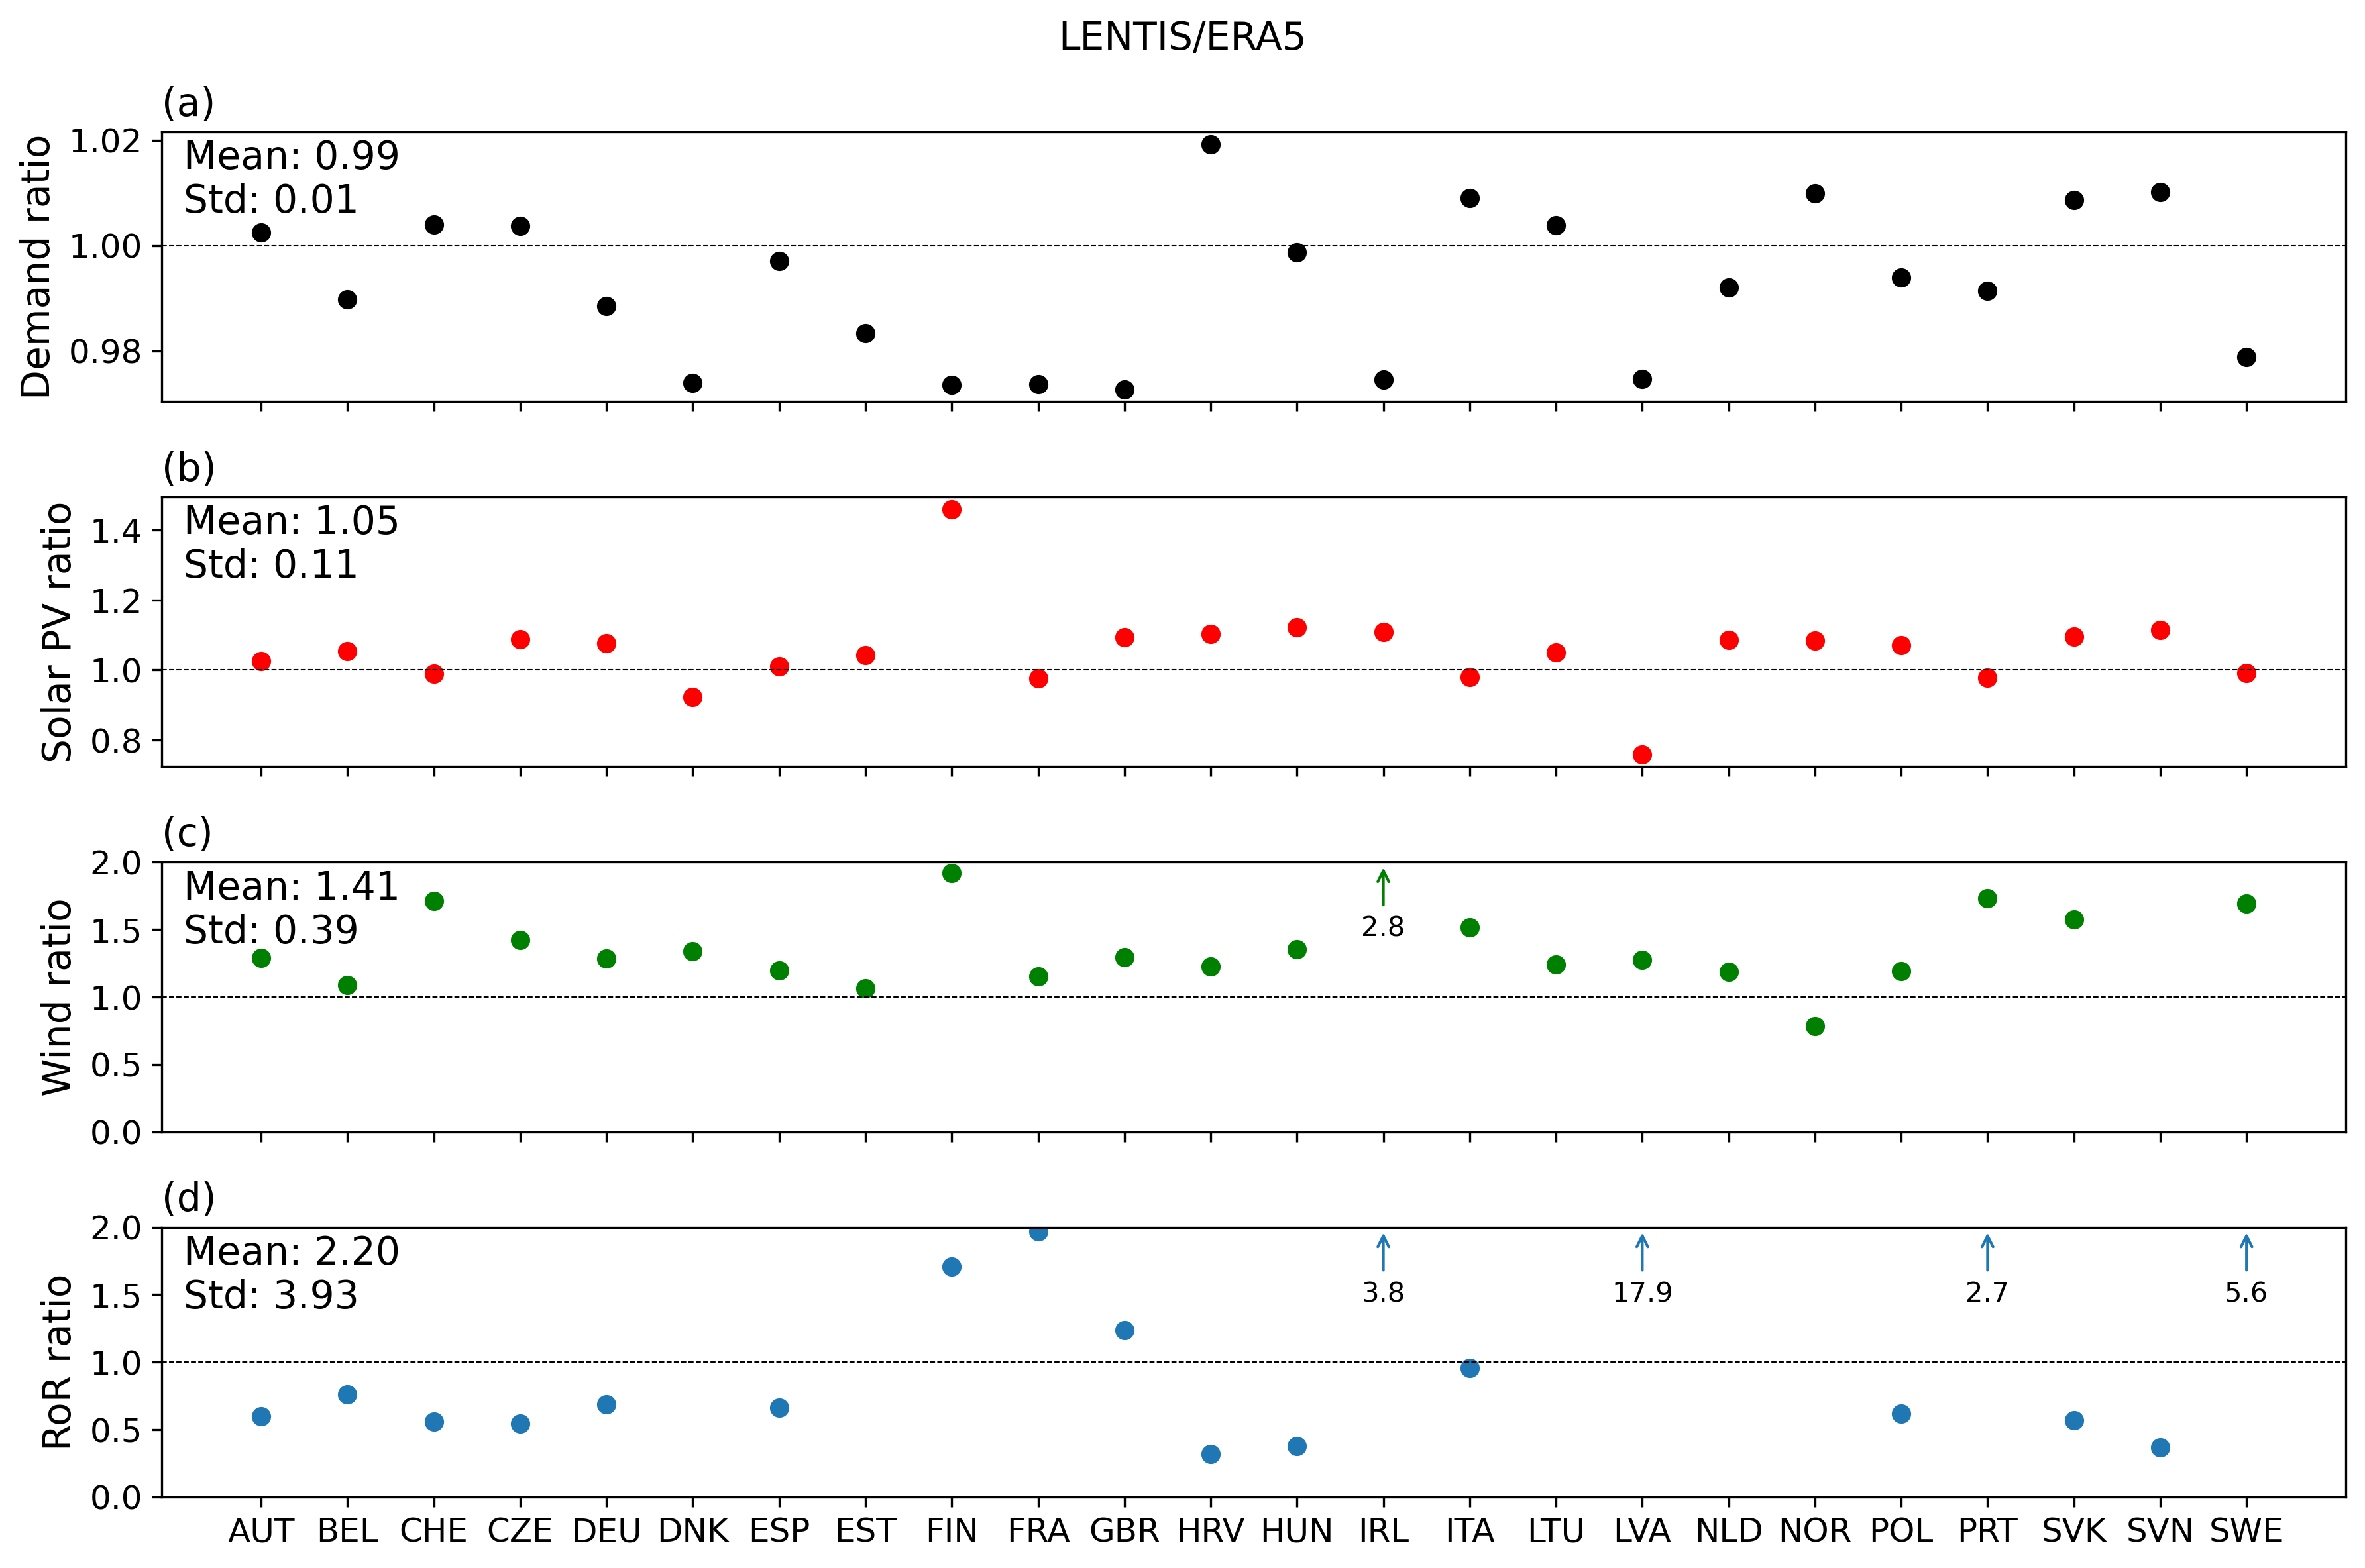

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True, dpi = 300)

axs[0].scatter(countries, demand_ratios_events, color = 'k')
axs[0].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[0].set_ylabel('Demand ratio', fontsize=fontsize_l)
axs[0].text(0.01, 0.7, f"Mean: {np.mean(demand_ratios_events):.2f}\nStd: {np.std(demand_ratios_events):.2f}", transform=axs[0].transAxes, fontsize=fontsize_l)
axs[0].set_title('(a)', loc = "left", fontsize=fontsize_l)
axs[0].tick_params(axis='both', labelsize=fontsize_s)

axs[1].scatter(countries, solar_ratios_events, color = 'r')
axs[1].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[1].set_ylabel('Solar PV ratio', fontsize=fontsize_l)
axs[1].text(0.01, 0.7, f"Mean: {np.mean(solar_ratios_events):.2f}\nStd: {np.std(solar_ratios_events):.2f}", transform=axs[1].transAxes, fontsize=fontsize_l)
axs[1].set_title('(b)', loc = "left", fontsize=fontsize_l)
axs[1].tick_params(axis='both', labelsize=fontsize_s)
# axs[1].set_ylim(0.97, 1.08)
# axs[1].set_yticks(np.arange(0.96, 1.08, 0.04))

axs[2].scatter(countries, wind_ratios_events, color = 'g')
axs[2].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
axs[2].set_ylabel('Wind ratio', fontsize=fontsize_l)
axs[2].text(0.01, 0.7, f"Mean: {np.nanmean(wind_ratios_events):.2f}\nStd: {np.nanstd(wind_ratios_events):.2f}", transform=axs[2].transAxes, fontsize=fontsize_l)
axs[2].set_title('(c)', loc = "left", fontsize=fontsize_l)
axs[2].set_ylim(0, 2)
indices = np.where(np.array(wind_ratios_events) >= 2)[0]
for i in indices:
    axs[2].annotate(round(wind_ratios_events[i], 1), xy=(countries[i], 2), xytext=(countries[i], 1.6),
                    textcoords='data', ha='center', va='top',
                    arrowprops=dict(color='g', arrowstyle='->', connectionstyle='arc3,rad=0'))
axs[2].tick_params(axis='both', labelsize=fontsize_s)

axs[3].scatter(countries, ror_ratios_events, color = 'C0')
axs[3].axhline(y=1, color='k', linestyle='--', linewidth=0.5)
plt.ylim(0, 2)
axs[3].set_ylabel('RoR ratio', fontsize=fontsize_l)
axs[3].text(0.01, 0.7, f"Mean: {np.nanmean(ror_ratios_events):.2f}\nStd: {np.nanstd(ror_ratios_events):.2f}", transform=axs[3].transAxes, fontsize=fontsize_l)
indices = np.where(np.array(ror_ratios_events) >= 2)[0]
for i in indices:
    axs[3].annotate(round(ror_ratios_events[i], 1), xy=(countries[i], 2), xytext=(countries[i], 1.6),
                    textcoords='data', ha='center', va='top',
                    arrowprops=dict(color='C0', arrowstyle='->', connectionstyle='arc3,rad=0'))
axs[3].set_title('(d)', loc = "left", fontsize=fontsize_l)
axs[3].tick_params(axis='both', labelsize=fontsize_s)

fig.suptitle('LENTIS/ERA5', fontsize=fontsize_l)
plt.tight_layout()
plt.show()